In [240]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

"""Change to the data folder"""
new_path = "./new_train/new_train"
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [62]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [168]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
#     out = [numpy.dstack([scene['p_out']]) for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    inp = torch.tensor(inp, dtype=torch.float)
    out = torch.tensor(out, dtype=torch.float)
    return [inp, out]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)


### Visualize the batch of sequences

<ipython-input-156-b8a574584fb7>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-156-b8a574584fb7>:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)


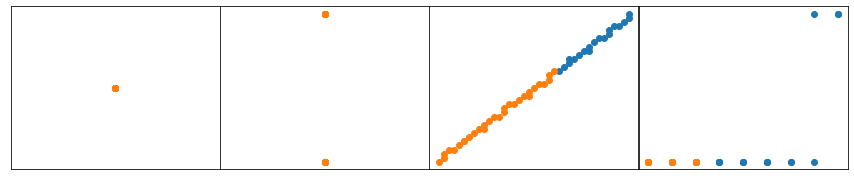

In [157]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break

In [381]:
class NN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(NN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
#         out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [384]:
from tqdm import tqdm_notebook as tqdm
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(iterator):
        data, target = torch.reshape(data, (4, 60, -1)).to(device), torch.reshape(target[:,:,:,:2], (4, 60, -1)).to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
#         break
        loss = nn.MSELoss()(output, target)
#         print(loss)
        loss.backward()
        optimizer.step()
        counter += 1
        iterator.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))

In [ ]:
# input dimension
input_dim = 76
hidden_dim = 60  # hidden layer dimension
layer_dim = 1   # number of hidden layers
output_dim = 60   # output dimension

net = NN(input_dim, output_dim, hidden_dim, layer_dim)

learning_rate = 0.0001
momentum = 0.5
device = "cpu"
model = net.to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=1e-5)
num_epoch = 10

for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)

<ipython-input-384-ce3c0e6d0533>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/51486 [00:00<?, ?it/s]

<ipython-input-168-3cc807f2c76d>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-168-3cc807f2c76d>:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)
<ipython-input-168-3cc807f2c76d>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp, dtype=torch.float)
<ipython-input-168-3cc807f2c76d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens